# CoRe package benchmarking

We provide a systematic assessment of the core fitness genes identified by the methods implemented in the CoRe package, namely the 90-th percentile ranking method and the Adaptive Daisy Model (ADaM).
As testing, we use the CERES integrated dependency dataset (release 1 Sanger, version 20Q2 Broad). It has been shown in [1] that CERES provides a dataset optimized for the identification of a priori known essential and non-essential genes. The CERES dataset is scaled using curated BAGEL essential and non-essential genes [2], so that the median of the former is equal to -1 and the median of the latter is equal to 0 for every cell line.
Since ADaM works with binary data, we binarized the CERES matrix considering all the instances having a fold-change score less than -0.5 as essential, otherwise they are deemed non-essential.

__References__ <br>
[1] C. Pacini et al., “Integrated cross-study datasets of genetic dependencies in cancer”, Nat. Commun., vol. 12, no. 1, p. 1661, 2021, doi: 10.1038/s41467-021-21898-7. <br>
[2] F. M. Behan et al., “Prioritization of cancer therapeutic targets using CRISPR–Cas9 screens”, Nature, 2019, doi: 10.1038/s41586-019-1103-9

In [2]:
options(warn=-1)

library(tidyverse)
library(pheatmap)
library(CoRe)
library(magrittr)

## curated sets of BAGEL genes
data('curated_BAGEL_essential')
data('curated_BAGEL_nonEssential')

## CERES scaling
scale_to_essentials <- function(ge_fit,ess_genes,noness_genes){
  essential_indices <- which(row.names(ge_fit) %in% ess_genes)
  nonessential_indices <- which(row.names(ge_fit) %in% noness_genes)
  scaled_ge_fit <- ge_fit %>%
    apply(2, function(x){
      (x - median(x[nonessential_indices], na.rm=T)) %>%
        divide_by(median(x[nonessential_indices], na.rm=T) - median(x[essential_indices], na.rm=T))
    })
  return(scaled_ge_fit)
}

## download CERES integrated dataset
url <- 'https://www.depmap.org/broad-sanger/integrated_Sanger_Broad_essentiality_matrices_20201201.zip'
temp <- tempfile()
download.file(url, temp, mode="wb") 
unzip(temp, exdir = 'integrated_dataset')
unlink(temp)

depFC <- read.table('integrated_dataset/integrated_Sanger_Broad_essentiality_matrices_20201201/CERES_FC.txt', 
                    row.names = 1, sep = '\t', header = TRUE, stringsAsFactors = FALSE, check.names = FALSE)
system('rm -r integrated_dataset')

## download cell line annotation from the Cell Model Passports
clannotation <- read_csv('data/model_list_20210326.csv')

## convert model IDs to model names
depFC <- depFC[,-which(is.na(colSums(depFC)))]
cells <- colnames(depFC)

tot_id <- clannotation %>% filter(model_id %in% cells | BROAD_ID %in% cells) %>% 
  select(model_name,model_id,BROAD_ID) %>% 
  pivot_longer(cols = c("model_id","BROAD_ID"), names_to = "institute", values_to = "model_id") %>% 
  select(model_name,model_id) %>% filter(model_id %in% cells) %>% 
  arrange(factor(model_id, levels = cells))

depFC <- depFC[,which(cells %in% tot_id$model_id)]
colnames(depFC) <- tot_id$model_name
scaled_depFC <- scale_to_essentials(depFC,curated_BAGEL_essential,curated_BAGEL_nonEssential)

bdep <- apply(scaled_depFC, 2, function(x){
  x[which(x >= -0.5)] <- 0
  x[which(x < -0.5)] <- 1
  x
}) 

── Attaching packages ─────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  pmed = col_double(),
  mutational_burden = col_double(),
  ploidy = col_double(),
  mutation_data = col_logical(),
  methylation_data = col_logical(),
  expression_data = col_logical(),
  cnv_data = col_logical(),
 

## Computation of pan-cancer core-fitness genes

In this section, we compute the pan-cancer core-fitness genes using ADaM with cancer tissues constituted by at least 15 cell lines and the four variants of the 90-th percentile ranking method.
For a detailed description of the methods, please visit the github page: https://github.com/DepMap-Analytics/CoRe.

In [3]:
## determining tissues with at least 15 cell lines in the dependency matrix
tissues_ctypes<-
  names(which(summary(as.factor(clannotation$tissue[match(colnames(bdep),clannotation$model_name)]))>=15))

print('ADaM will be executed at the tissue type level on the following tissue lineages:')
print(tissues_ctypes)

[1] "ADaM will be executed at the tissue type level on the following tissue lineages:"
 [1] "Biliary Tract"               "Bladder"                    
 [3] "Bone"                        "Breast"                     
 [5] "Central Nervous System"      "Endometrium"                
 [7] "Esophagus"                   "Haematopoietic and Lymphoid"
 [9] "Head and Neck"               "Kidney"                     
[11] "Large Intestine"             "Liver"                      
[13] "Lung"                        "Ovary"                      
[15] "Pancreas"                    "Peripheral Nervous System"  
[17] "Skin"                        "Soft Tissue"                
[19] "Stomach"                    


In [4]:
## ADaM
ADaM <- CoRe.PanCancer_ADaM(bdep,
                            tissues_ctypes,
                            clannotation = clannotation,
                            display=FALSE,
                            ntrials=1000,
                            verbose=FALSE,
                            TruePositives = curated_BAGEL_essential)

## 90-th percentile with fixed strategy
Perc_fixed <- CoRe.FiPer(scaled_depFC,
                         display=FALSE,
                         method = 'fixed')$cfgenes

## 90-th percentile with avg strategy
Perc_avg <- CoRe.FiPer(scaled_depFC,
                       display=FALSE,
                       method = 'average')$cfgenes

## 90-th percentile with slope strategy
Perc_slope <- CoRe.FiPer(scaled_depFC,
                         display=FALSE,
                         method = 'slope')$cfgenes

## 90-th percentile with AUC strategy
Perc_AUC <- CoRe.FiPer(scaled_depFC,
                       display=FALSE,
                       method = 'AUC')$cfgenes

## common core-fitness genes
Perc_Consensus <- Reduce(intersect,list(Perc_fixed,Perc_avg,Perc_slope,Perc_AUC))

## Summary statistics

To extend our comparison, we also decided to include the core-fitness (CF) genes predicted by the ADaM method in [1], by CEN-tools in [2] and by CEN-tools using the curated BAGEL genes as training sets on the CERES dataset we just computed. Also the Hart essential genes in [3] and the new version presented in [4] are taken into account. <br>
First, we show the number of core-fitness genes for each set under consideration and then we compute the similarity among them.

__References__ <br>
[1] F. M. Behan et al., “Prioritization of cancer therapeutic targets using CRISPR–Cas9 screens”, Nature, 2019, doi: 10.1038/s41586-019-1103-9. <br>
[2] S. Sharma, C. Dincer, P. Weidemüller, G. J. Wright, and E. Petsalaki, “<scp>CEN</scp>‐tools: an integrative platform to identify the contexts of essential genes”, Mol. Syst. Biol., vol. 16, no. 10, Oct. 2020, doi: 10.15252/msb.20209698. <br>
[3] T. Hart et al., “High-Resolution CRISPR Screens Reveal Fitness Genes and Genotype-Specific Cancer Liabilities”, Cell, vol. 163, no. 6, pp. 1515–26, Dec. 2015, doi: 10.1016/j.cell.2015.11.015. <br>
[4]	T. Hart et al., “Evaluation and Design of Genome-Wide CRISPR/SpCas9 Knockout Screens”, G3, Genes|Genomes|Genetics, vol. 7, no. 8, pp. 2719–2727, Aug. 2017, doi: 10.1534/g3.117.041277.

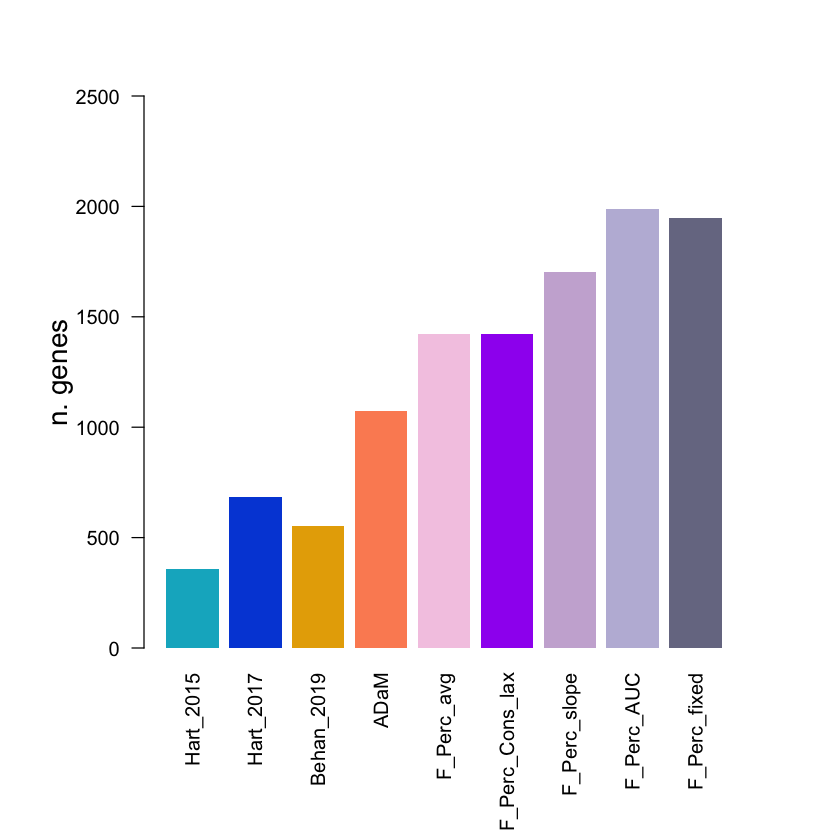

In [5]:
## Essentials genes obtained with CENtools using BAGEL curated genes as reference sets (default nº bin = 20)
load('data/CENtools_Essentials.RData')

## CENtools
CENtools_SV1_B20Q2_CERES <- CENtools_ess

## CENtools Sharma et al, 2020
CENtools_2020<-read.table(file = 'data/CenTools_essential_Sharma_et_al.txt',sep='\t',stringsAsFactors = FALSE)$V1

## ADaM essential Behan et al., 2019
load('data/ADaM_CFs_Behan_et_Al_2019.RData')
ADaM_2019<-PanCancerCoreFitnessGenes

## Hart et al., 2015
data(BAGEL_essential)
Hart_Essential_2015<-BAGEL_essential

## Hart et al., 2017
load('data/BAGEL_v2_Essentials.RData')
Hart_Essential_2017<-BAGEL_essential

##### Barplot comparing n. of predicted CF genes
CFs_sets<-list(Hart_2015 = Hart_Essential_2015,
               Hart_2017 = Hart_Essential_2017,
               Behan_2019 = ADaM_2019,
               ADaM = ADaM,
               F_Perc_avg = Perc_avg,
               F_Perc_Cons_lax = Perc_Consensus,
               F_Perc_slope = Perc_slope,
               F_Perc_AUC = Perc_AUC,
               F_Perc_fixed = Perc_fixed)

col=c("#03B2C8","#034DD9","#E6AB02","#1B9E77","#337100","#FC8D62",'black',
      "#F4CAE4",'purple',"#CAB2D6","#BEBADA","#777892")
names(col)<-c("Hart_2015","Hart_2017","Behan_2019","Sharma_2020","CENtools","ADaM",
              "F_Perc_Cons","F_Perc_avg","F_Perc_Cons_lax","F_Perc_slope","F_Perc_AUC","F_Perc_fixed")

par(mar=c(8,6,4,4))
barplot(unlist(lapply(CFs_sets,length)),ylab='n. genes',las=2,border = FALSE,col=col[names(CFs_sets)],
        cex.lab = 1.4, cex.main = 2, ylim = c(0,2500))

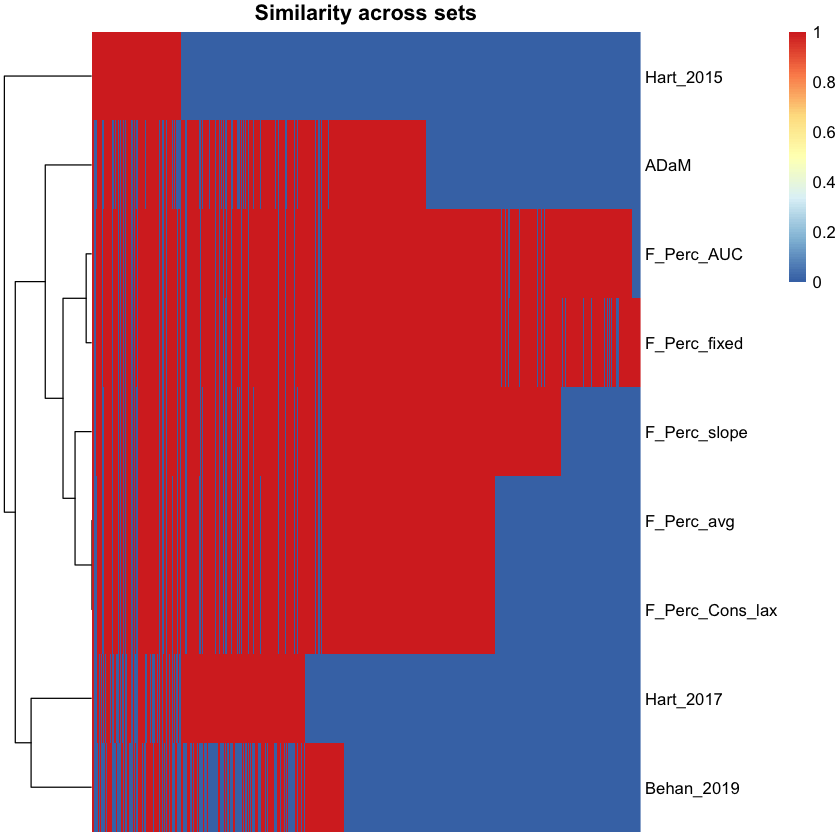

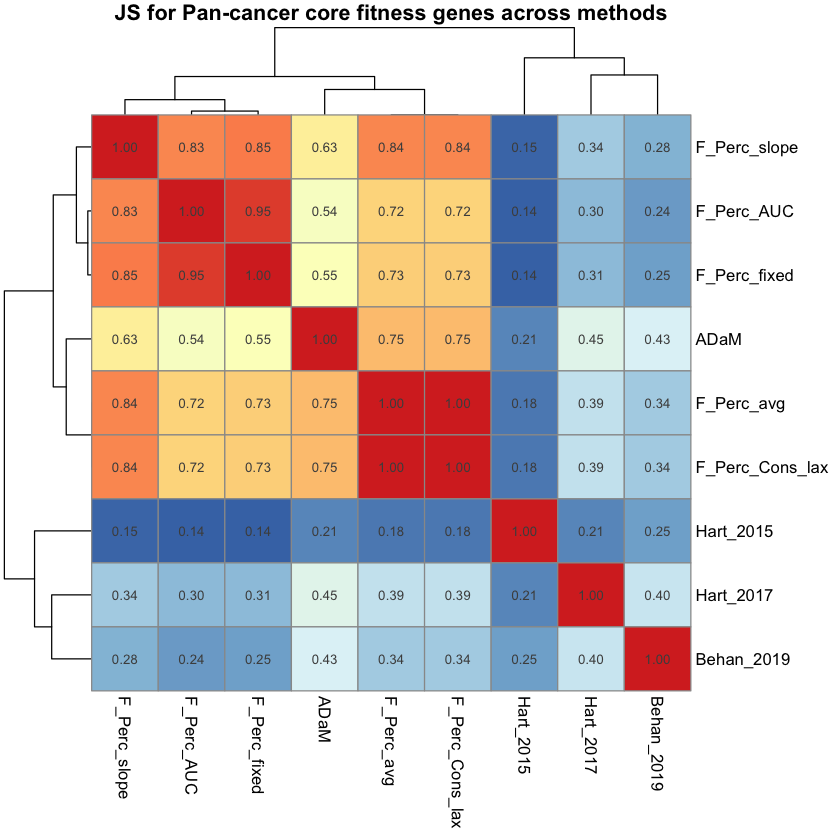

In [6]:
##### CF gene set similarity
allEss<-unique(unlist(CFs_sets))
membMat<-do.call(rbind,lapply(CFs_sets,function(x){is.element(allEss,x)}))
rownames(membMat)<-names(CFs_sets)
colnames(membMat)<-allEss
membMat<-membMat+0

pheatmap(membMat,show_colnames = FALSE,clustering_distance_rows = 'binary',cluster_cols = FALSE,border_color = NA,
         main = 'Similarity across sets')

dmat<-dist(membMat,method = 'binary')

pheatmap(1-as.matrix(dmat), main = 'JS for Pan-cancer core fitness genes across methods', 
         legend = FALSE,display_numbers = round(dmat,digits = 2))

## Baseline predictor

A baseline predictor is defined by considering CF genes those essential in at least n cell lines for all n. We compute the recall of this predictor using independent sets of a priori known essential genes (i.e. those involved in housekeeping cellular processes like translation or replication) [1-2]. <br>
In addition, gene dependencies associated with a biomarker are very specific to the molecular context, therefore, these genes classified as CF are deemed false positives (FP). In the FP set are included also the non-expressed genes. We compute the recall of these FP genes for the baseline predictor.

__References__ <br>
[1]	F. Iorio et al., “Unsupervised correction of gene-independent cell responses to CRISPR-Cas9 targeting,” BMC Genomics, 2018, doi: 10.1186/s12864-018-4989-y. <br>
[2]	C. Pacini et al., “Integrated cross-study datasets of genetic dependencies in cancer,” Nat. Commun., vol. 12, no. 1, p. 1661, 2021, doi: 10.1038/s41467-021-21898-7.

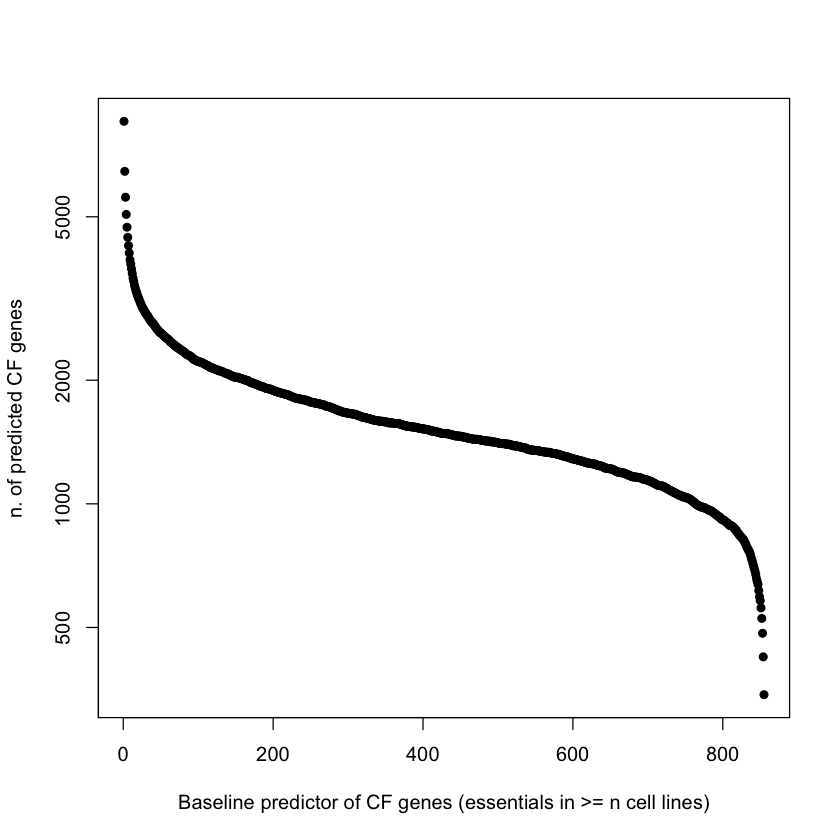

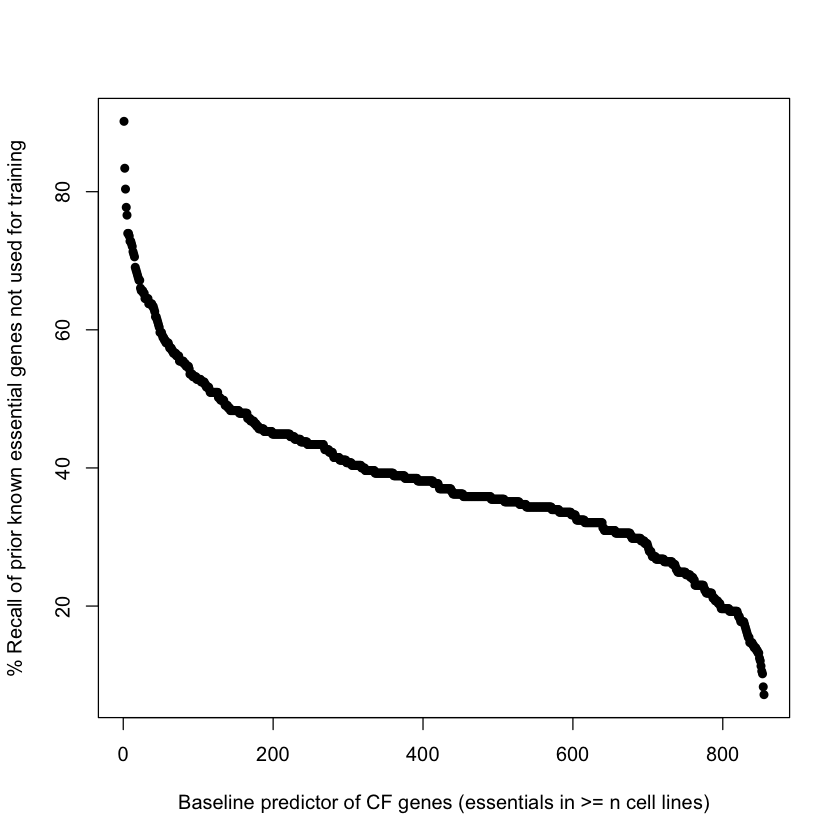

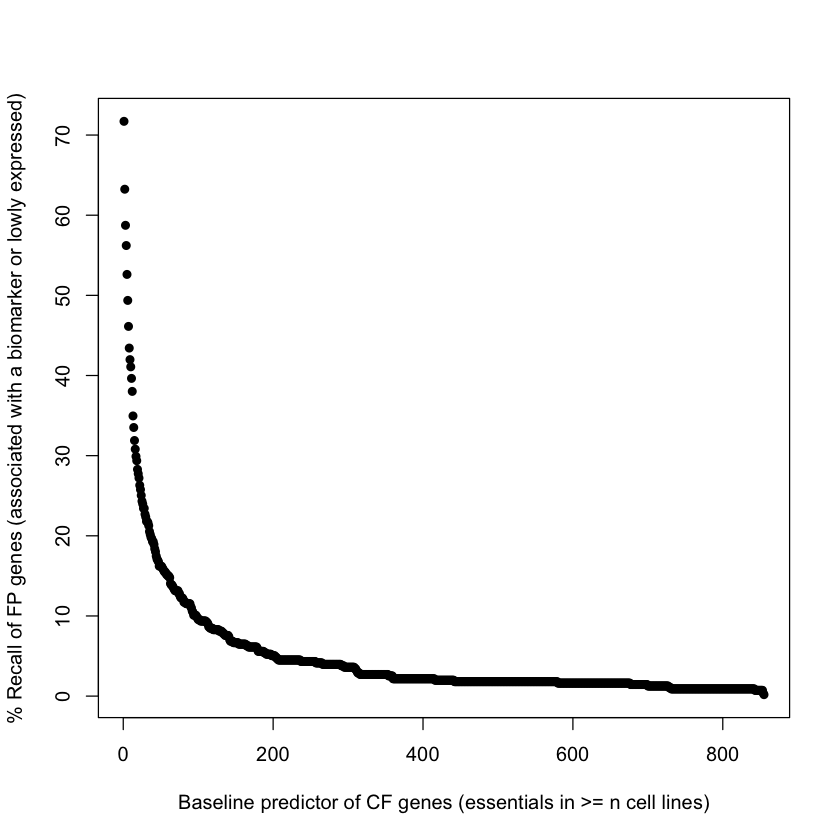

In [7]:
##### Ability to identify novel hits
CFs_sets<-list(Behan_2019 = ADaM_2019,
               Sharma_2020 = CENtools_2020,
               CENtools = CENtools_SV1_B20Q2_CERES,
               ADaM = ADaM,
               F_Perc_avg = Perc_avg,
               F_Perc_Cons_lax = Perc_Consensus,
               F_Perc_slope = Perc_slope,
               F_Perc_AUC = Perc_AUC,
               F_Perc_fixed = Perc_fixed)

## Assembling a set of prior known essential genes that are not included in the
## training sets used by CENtools and/or ADaM
data(EssGenes.DNA_REPLICATION_cons)
data(EssGenes.KEGG_rna_polymerase)
data(EssGenes.PROTEASOME_cons)
data(EssGenes.SPLICEOSOME_cons)
data(EssGenes.ribosomalProteins)
data(EssGenes.HISTONES)

signatures<-list(DNA_REPLICATION=EssGenes.DNA_REPLICATION_cons,
                 RNA_POLYMERASE=EssGenes.KEGG_rna_polymerase,
                 PROTEASOME=EssGenes.PROTEASOME_cons,
                 SPLICEOSOME=EssGenes.SPLICEOSOME_cons,
                 RIBOSOMAL_PROTS=EssGenes.ribosomalProteins,
                 HISTONES=EssGenes.HISTONES)

signatures<-unique(unlist(signatures))

geneSet <- rownames(scaled_depFC)

## Adding additional signatures in Pacini et al, 2020
load("data/Kegg.DNArep.Rdata")
load("data/Kegg.Ribosome.Rdata")
load("data/Kegg.Proteasome.Rdata")
load("data/Kegg.Spliceosome.Rdata")
load("data/Kegg.RNApoly.Rdata")
load("data/Histones.Rdata")

allRefEss<-unique(c(Kegg.DNArep,Kegg.Proteasome,Kegg.Ribosome,Kegg.RNApoly,Kegg.Spliceosome,Histones))

signatures<-union(signatures,allRefEss)
signatures <- intersect(signatures,geneSet)

## training sets used by ADaM/CENtools while executed on the new joint dataset
## and by ADaM on the old dataset
BAG_genes <- unique(c(curated_BAGEL_essential,
                      curated_BAGEL_nonEssential,
                      BAGEL_essential,
                      BAGEL_nonEssential))

## removing training sets used by ADaM/CENtools while executed on the new joint dataset
## and by ADaM on the old dataset
signatures <- setdiff(signatures,BAG_genes)
geneSet_noBAG <- setdiff(geneSet,BAG_genes)

## baseline predictor
baselineCFs <- lapply(1:ncol(bdep),function(x){
  names(which(rowSums(bdep)>=x))
})

baselineSizes<-unlist(lapply(baselineCFs,length))

baselineRecalls<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,signatures))/length(signatures)
}))

load('data/CMP_RNAseq.Rdata')

## genes not expressed
lowlyExp<-names(which(rowSums(CMP_RNAseq<0.01,na.rm=TRUE)>=ncol(CMP_RNAseq)))

## dependency associated with biomarkers
FPs <- sort(unique(unlist(read.table('data/dependency_with_biomarkers.txt',stringsAsFactors = FALSE))))
FPs <- union(FPs,lowlyExp)
FPs <- intersect(FPs,geneSet_noBAG)

baselineNEratio<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,FPs))/length(FPs)
}))

plot(baselineSizes,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)', 
     ylab='n. of predicted CF genes',pch=16,log='y')

plot(baselineRecalls,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of prior known essential genes not used for training',pch=16)

plot(baselineNEratio,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of FP genes (associated with a biomarker or lowly expressed)',pch=16)

## Comparison between method considering novel hits

The metrics derived from the baseline predictors are then used to assess the CF sets predicted by each method. We consider the CF sets without the BAGEL genes used for the training of CEN-tools, namely BAGEL essential version 2 and non-essential used for Sharma_2020 set, and curated BAGEL essential and non-essential used for CENtools set. <br>
In the first plot, we normalised the recall of the signatures by the maximum recall achieved by the baseline predictor. The 90-th percentile variants have a higher ratio since they are less stringent. <br>
In the second plot, we show the recall ratio of the FP genes. ADaM and CEN-tools tend to show a higher stringency than the 90-th percentile variants, though the 'average' variant ratio is close to the ADaM and CEN-tools sets. <br>

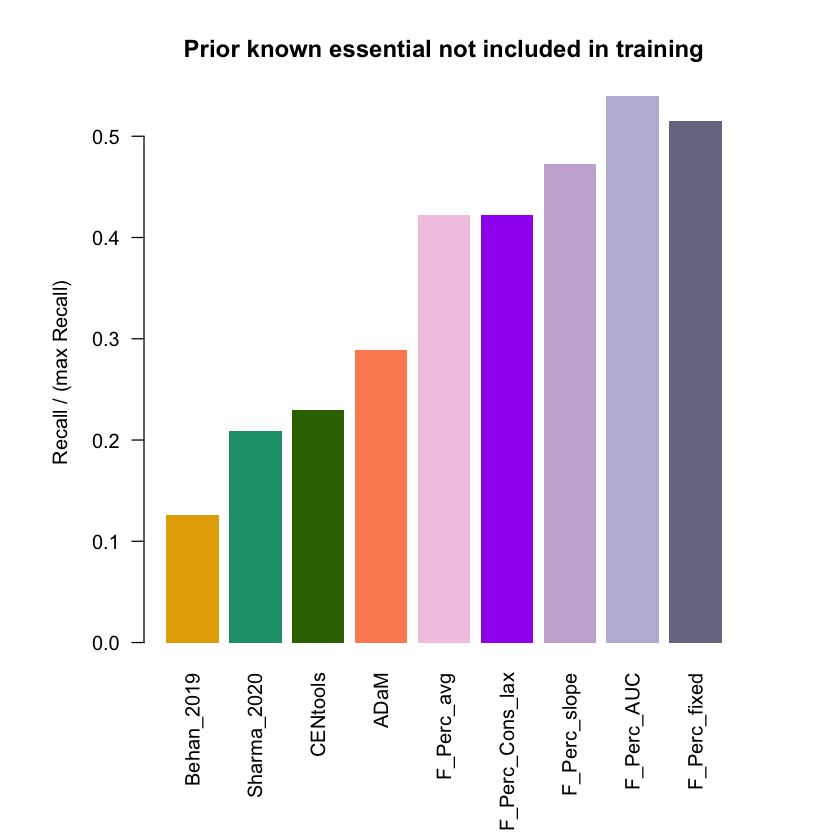

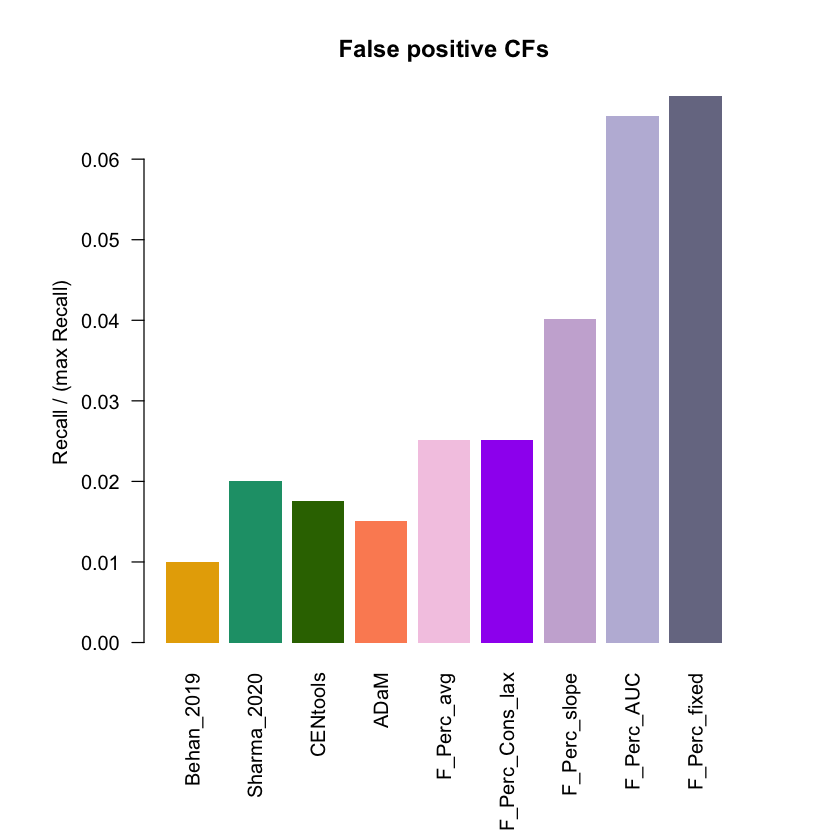

In [8]:
fCFs_sets <- lapply(CFs_sets,function(x){
  setdiff(x,BAG_genes)
})

observed_recalls<-100*unlist(lapply(fCFs_sets,
                                    function(x){length(intersect(x,signatures))/length(signatures)}))

observed_FPs<-100*unlist(lapply(fCFs_sets,
                                function(x){length(intersect(x,FPs))/length(FPs)}))

par(mar=c(8,6,4,4))
barplot(observed_recalls/max(baselineRecalls),col=col[names(observed_recalls)],
        las=2,ylab='Recall / (max Recall)',border=NA,main = 'Prior known essential not included in training')

barplot(observed_FPs/max(baselineNEratio),col=col[names(observed_FPs)],
        las=2,ylab='Recall / (max Recall)', border=NA, main = 'False positive CFs')

However, in order to have a fair comparison between the methods, we need to compare both the recall of prior known essential genes (from here on referred as true positive, TP) and the recall of FP genes to the baseline predictor. To do so we draw the relationship between TP and FP genes for the baseline predictor and show where each method stand. This approach shows that the 90-th percentile variants are more stringent than CEN-tools and ADaM when the size of predicted CF genes is taken into account.

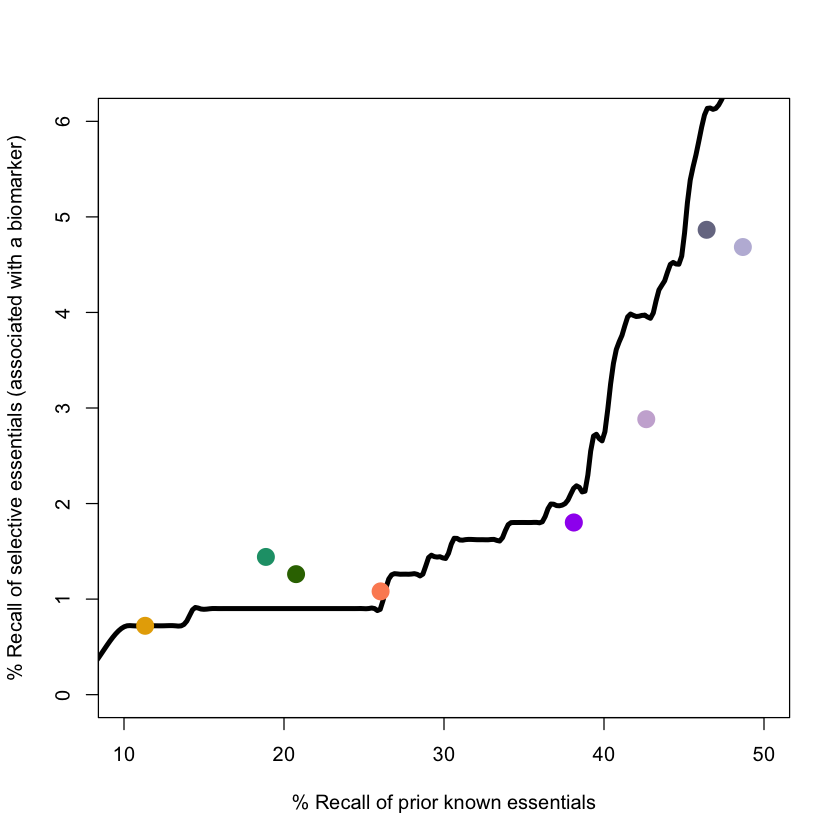

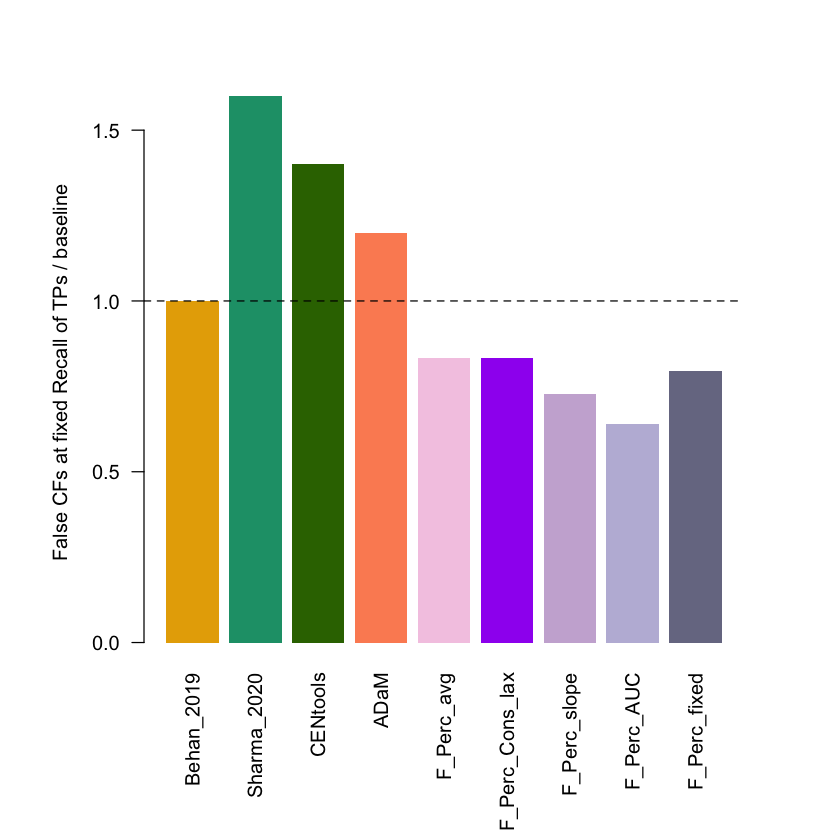

In [9]:
plot(spline(baselineRecalls,baselineNEratio),pch=16,
     xlab='% Recall of prior known essentials',
     ylab='% Recall of selective essentials (associated with a biomarker)',type='l',lwd=4,
     xlim=c(10,50),ylim=c(0,6))

points(observed_recalls,observed_FPs,col=col[names(observed_FPs)],pch=16,cex=2)

s0fun<-splinefun(baselineRecalls,baselineNEratio)

par(mar=c(8,6,4,4))
barplot(observed_FPs/s0fun(observed_recalls),col=col[names(observed_FPs)],
        las=2,border=NA,ylab='False CFs at fixed Recall of TPs / baseline')
abline(h=1,lty=2)

In the first plot, we show the threshold required by the baseline classifier to attain the observed recalls for each method. Although the 90-th percentile variants have lower threshold, they score higher when considering the median dependent cell lines of their CFs compared to the baseline classifier as shown in the second plot. This means that the predicted CF genes tend to be essential in a larger number of cell lines compared to CEN-tools and ADaM.

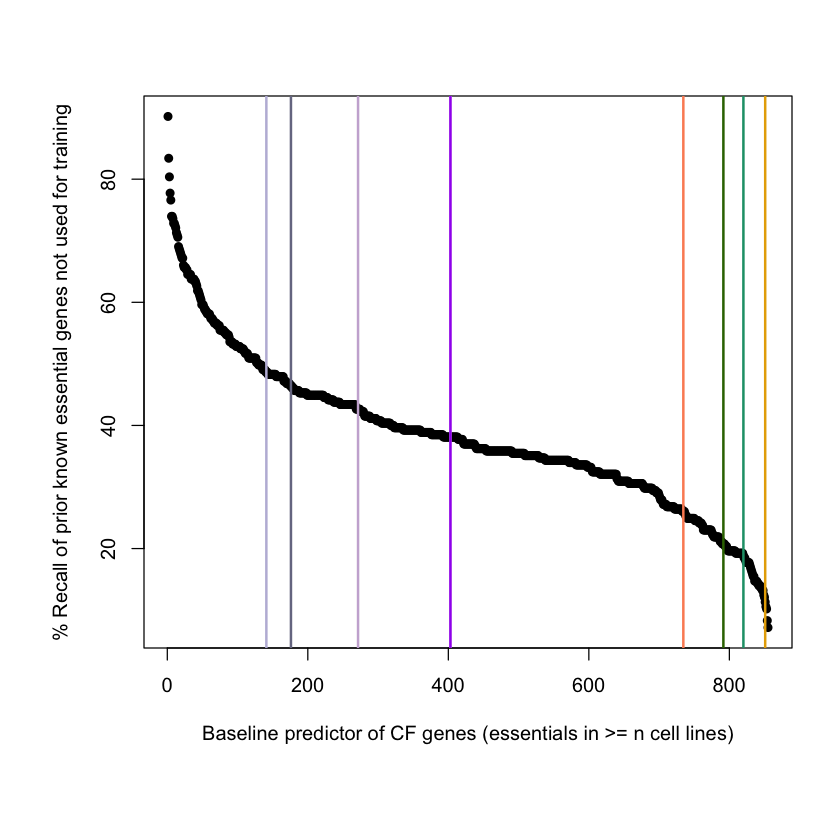

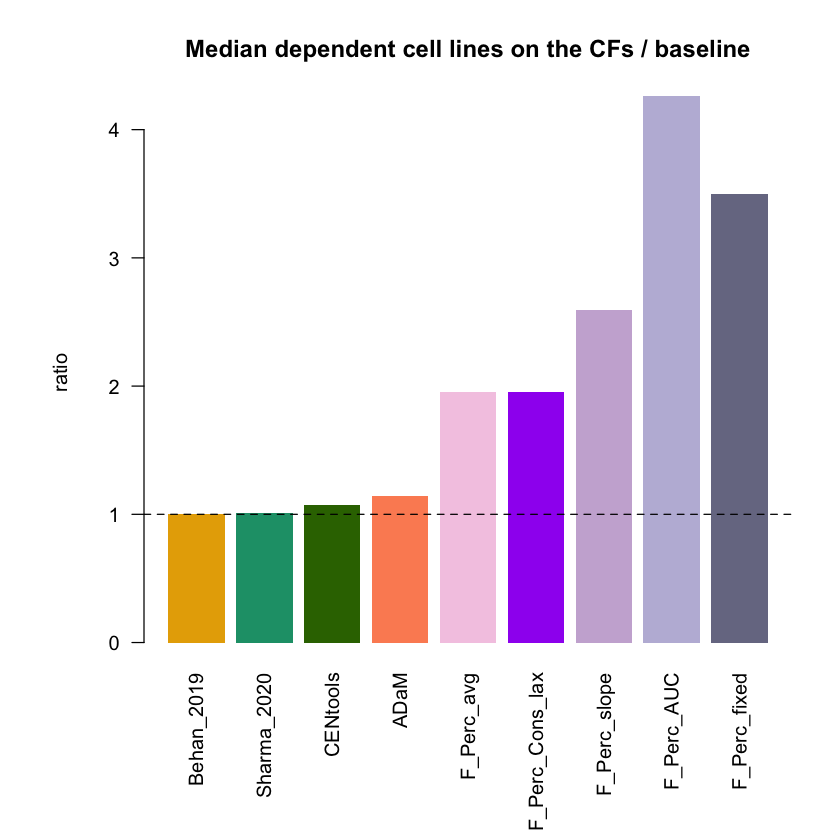

In [10]:
baselineRecalls<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,signatures))/length(signatures)
}))

par(mar=c(8,6,4,2))
plot(baselineRecalls,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of prior known essential genes not used for training',pch=16)

s0fun<-splinefun(baselineRecalls,1:length(baselineRecalls))
abline(v=s0fun(observed_recalls),col=col[names(observed_recalls)],lwd=2)

baseline_dep_cell_lines<-s0fun(observed_recalls)

median_n_dependent_cell_lines<-
  unlist(lapply(fCFs_sets,function(x){median(rowSums(bdep[intersect(x,geneSet),]))}))

barplot(median_n_dependent_cell_lines/baseline_dep_cell_lines,col=col[names(median_n_dependent_cell_lines)],
        las=2, border=NA,main = 'Median dependent cell lines on the CFs / baseline', ylab = 'ratio')
abline(h=1,lty=2)

In the first plot, we show the median fitness effect of the CF genes predicted by each method relative to the baseline predictor. CF genes predicted by the 90-th percentile variants have higher fitness score compared to ADaM and CEN-tools. This can be explained by the lower stringency of these methods that include genes with higher fitness score, therefore diluting the signal. <br>
In the second plot, we show the number of CF genes for each method compared to the baseline predictor.

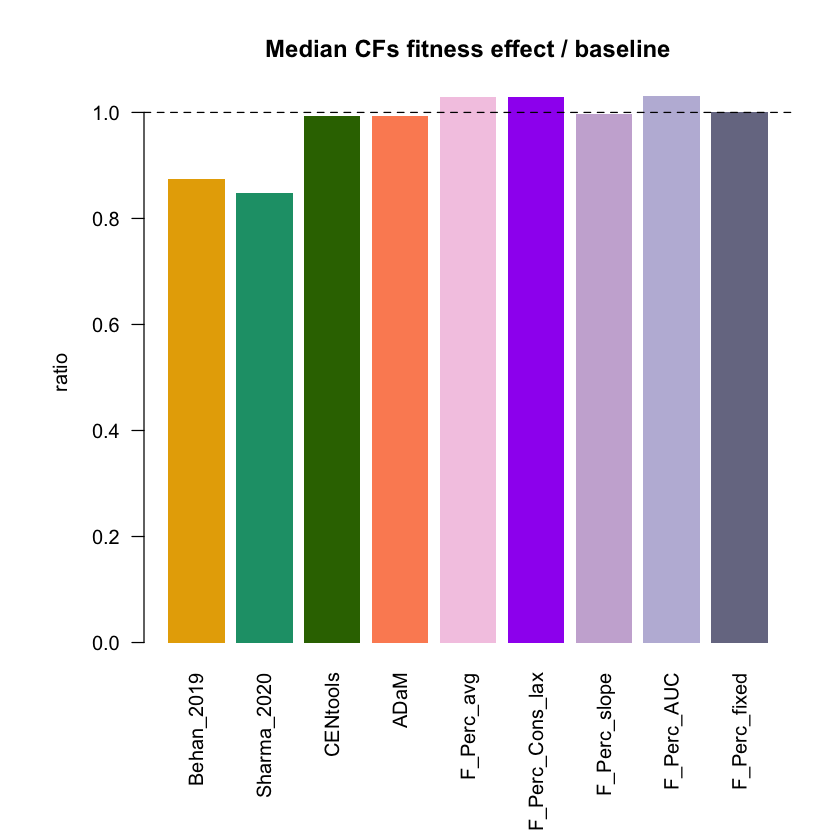

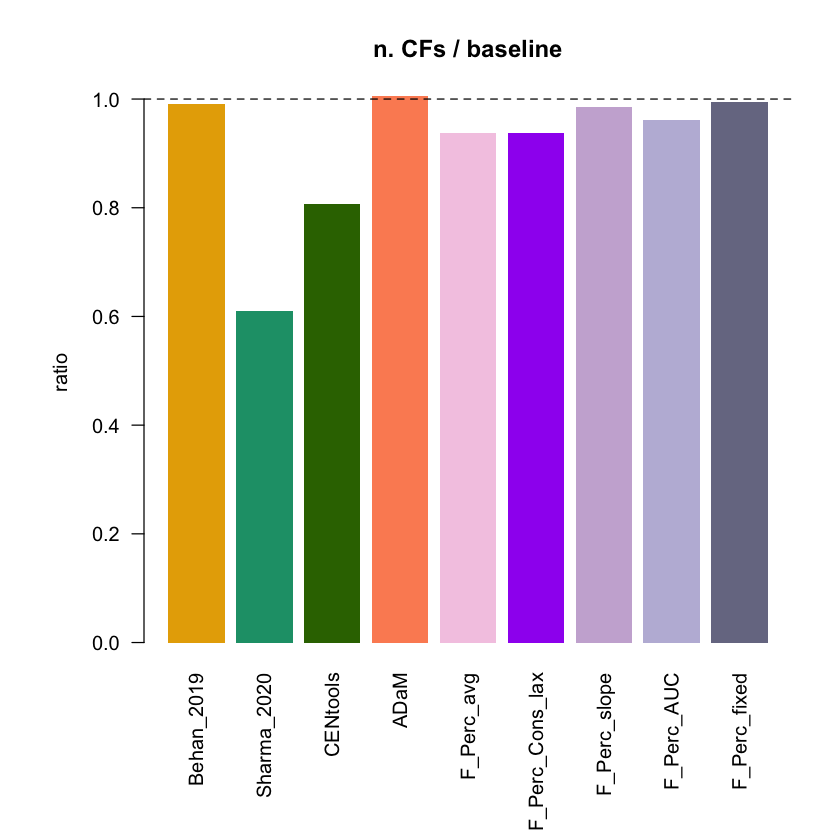

In [12]:
observed_sizes<-lapply(CFs_sets,length)

median_dep <- unlist(lapply(CFs_sets,
                function(x){median(apply(scaled_depFC[intersect(x,geneSet_noBAG),],1,median))}))

baseline_dep <- unlist(lapply(baselineCFs[round(s0fun(observed_recalls))],
                function(x){median(apply(scaled_depFC[intersect(x,geneSet_noBAG),],1,median))}))

par(mar=c(8,6,4,2))
barplot(median_dep/baseline_dep,col=col[names(median_dep)],
        las=2,main = 'Median CFs fitness effect / baseline', border=NA, ylab = 'ratio')
abline(h=1,lty=2)

baseline_size<-unlist(lapply(baselineCFs[round(s0fun(observed_recalls))],length))
observed_sizes<-unlist(observed_sizes)

barplot(observed_sizes/baseline_size,col=col[names(observed_sizes)],
        las=2,main = 'n. CFs / baseline',border=NA, ylab = 'ratio')
abline(h=1,lty=2)

## Comparison between methods accounting for BAGEL genes
We perform the same pipeline shown above, but this time including the BAGEL gene sets used in the training phase of CEN-tools sets.

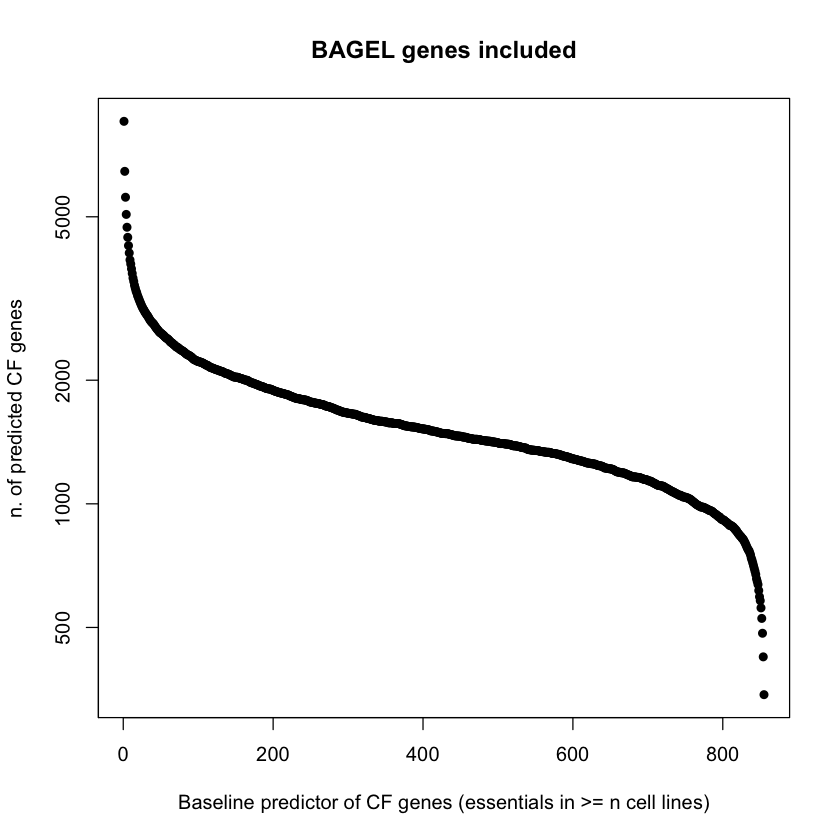

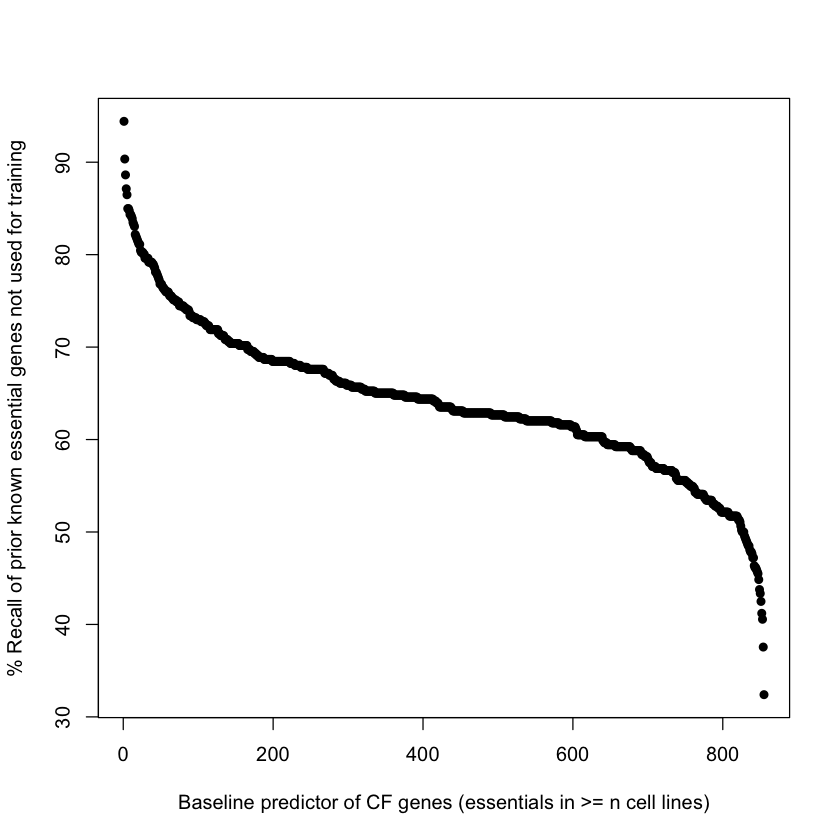

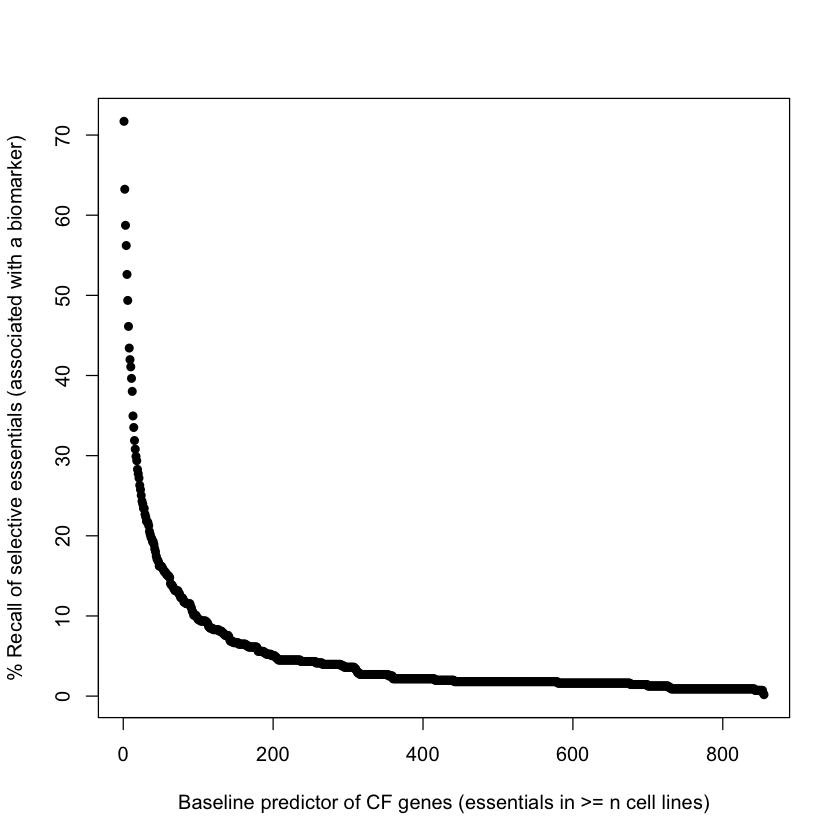

In [13]:
## Essentials genes obtained with CENtools using BAGEL curated genes as reference sets (default nº bin = 20)
load('data/CENtools_Essentials.RData')

## CENtools
CENtools_SV1_B20Q2_CERES <- c(CENtools_ess, curated_BAGEL_essential)

## CENtools Sharma et al, 2020
CENtools_2020 <- read.table(file = 'data/CenTools_essential_Sharma_et_al.txt',sep='\t',stringsAsFactors = FALSE)$V1
CENtools_2020 <- c(CENtools_2020, BAGEL_essential)

## ADaM essential Behan et al., 2019
load('data/ADaM_CFs_Behan_et_Al_2019.RData')
ADaM_2019<-PanCancerCoreFitnessGenes

## Hart et al., 2015
data(BAGEL_essential)
Hart_Essential_2015<-BAGEL_essential

## Hart et al., 2017
load('data/BAGEL_v2_Essentials.RData')
Hart_Essential_2017<-BAGEL_essential

col=c("#03B2C8","#034DD9","#E6AB02","#1B9E77","#337100","#FC8D62",'black',
      "#F4CAE4",'purple',"#CAB2D6","#BEBADA","#777892")
names(col) <- c("Hart_2015","Hart_2017","Behan_2019","Sharma_2020","CENtools","ADaM",
              "F_Perc_Cons","F_Perc_avg","F_Perc_Cons_lax","F_Perc_slope","F_Perc_AUC","F_Perc_fixed")

##### Ability to identify novel hits
CFs_sets<-list(Behan_2019 = ADaM_2019,
               Sharma_2020 = CENtools_2020,
               CENtools = CENtools_SV1_B20Q2_CERES,
               ADaM = ADaM,
               F_Perc_avg = Perc_avg,
               F_Perc_Cons_lax = Perc_Consensus,
               F_Perc_slope = Perc_slope,
               F_Perc_AUC = Perc_AUC,
               F_Perc_fixed = Perc_fixed)

## Assembling a set of prior known essential genes that are not included in the
## training sets used by CENtools and/or ADaM
signatures<-list(DNA_REPLICATION=EssGenes.DNA_REPLICATION_cons,
                 RNA_POLYMERASE=EssGenes.KEGG_rna_polymerase,
                 PROTEASOME=EssGenes.PROTEASOME_cons,
                 SPLICEOSOME=EssGenes.SPLICEOSOME_cons,
                 RIBOSOMAL_PROTS=EssGenes.ribosomalProteins,
                 HISTONES=EssGenes.HISTONES)

signatures<-unique(unlist(signatures))

## Adding additional signatures in Pacini et al, 2020
allRefEss<-unique(c(Kegg.DNArep,Kegg.Proteasome,Kegg.Ribosome,Kegg.RNApoly,Kegg.Spliceosome,Histones))

signatures<-union(signatures,allRefEss)
signatures <- intersect(signatures,geneSet)

## baseline predictor
baselineCFs <- lapply(1:ncol(bdep),function(x){
  names(which(rowSums(bdep)>=x))
})

baselineSizes<-unlist(lapply(baselineCFs,length))

baselineRecalls<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,signatures))/length(signatures)
}))

## genes not expressed
lowlyExp<-names(which(rowSums(CMP_RNAseq<0.01,na.rm=TRUE)>=ncol(CMP_RNAseq)))

## dependency associated with biomarkers
FPs <- sort(unique(unlist(read.table('data/dependency_with_biomarkers.txt',stringsAsFactors = FALSE))))
FPs <- union(FPs,lowlyExp)
FPs <- intersect(FPs,geneSet_noBAG)

baselineNEratio<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,FPs))/length(FPs)
}))

plot(baselineSizes,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)', 
     ylab='n. of predicted CF genes',pch=16,log='y', main = "BAGEL genes included")

plot(baselineRecalls,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of prior known essential genes not used for training',pch=16)

plot(baselineNEratio,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of selective essentials (associated with a biomarker)',pch=16)

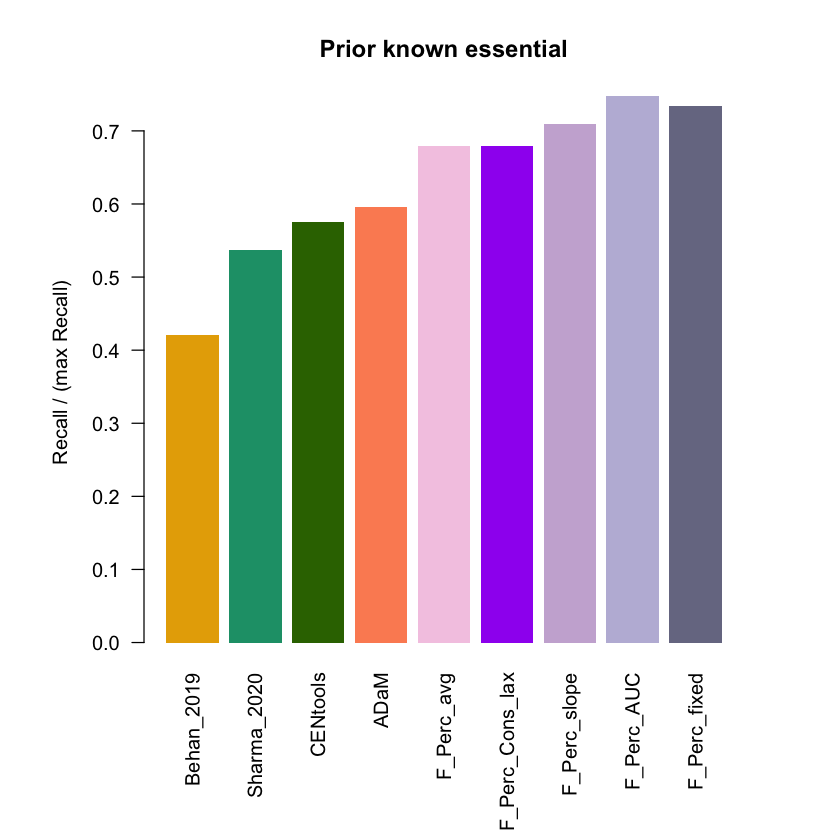

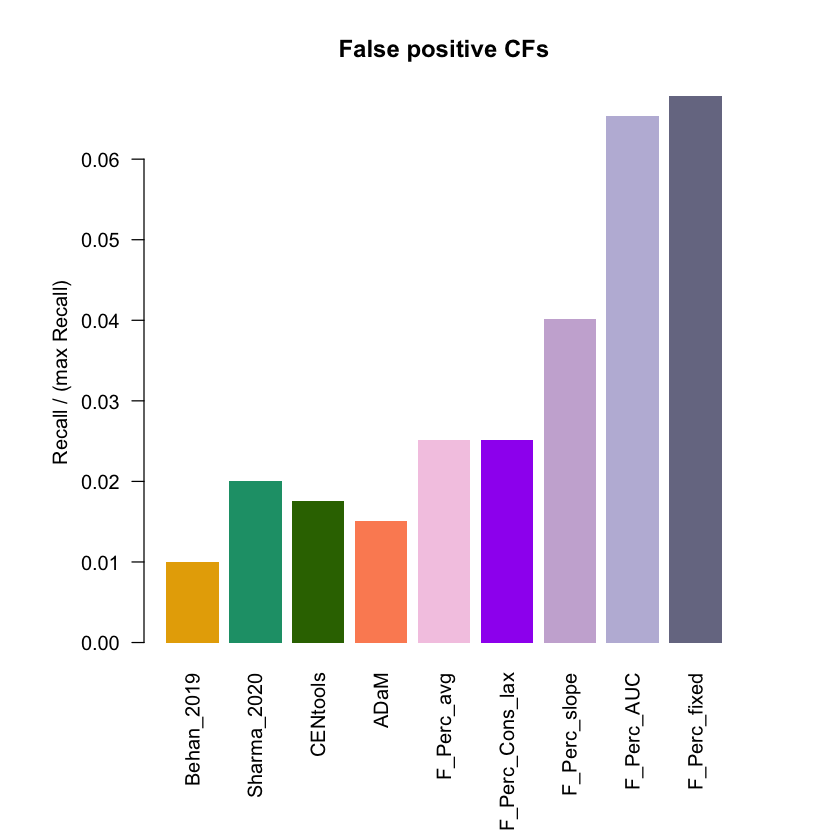

In [14]:
fCFs_sets <- CFs_sets

observed_recalls<-100*unlist(lapply(fCFs_sets,
                                    function(x){length(intersect(x,signatures))/length(signatures)}))

observed_FPs<-100*unlist(lapply(fCFs_sets,
                                function(x){length(intersect(x,FPs))/length(FPs)}))

par(mar=c(8,6,4,4))
barplot(observed_recalls/max(baselineRecalls),col=col[names(observed_recalls)],
        las=2,ylab='Recall / (max Recall)',border=NA,main = 'Prior known essential')

barplot(observed_FPs/max(baselineNEratio),col=col[names(observed_FPs)],
        las=2,ylab='Recall / (max Recall)', border=NA, main = 'False positive CFs')

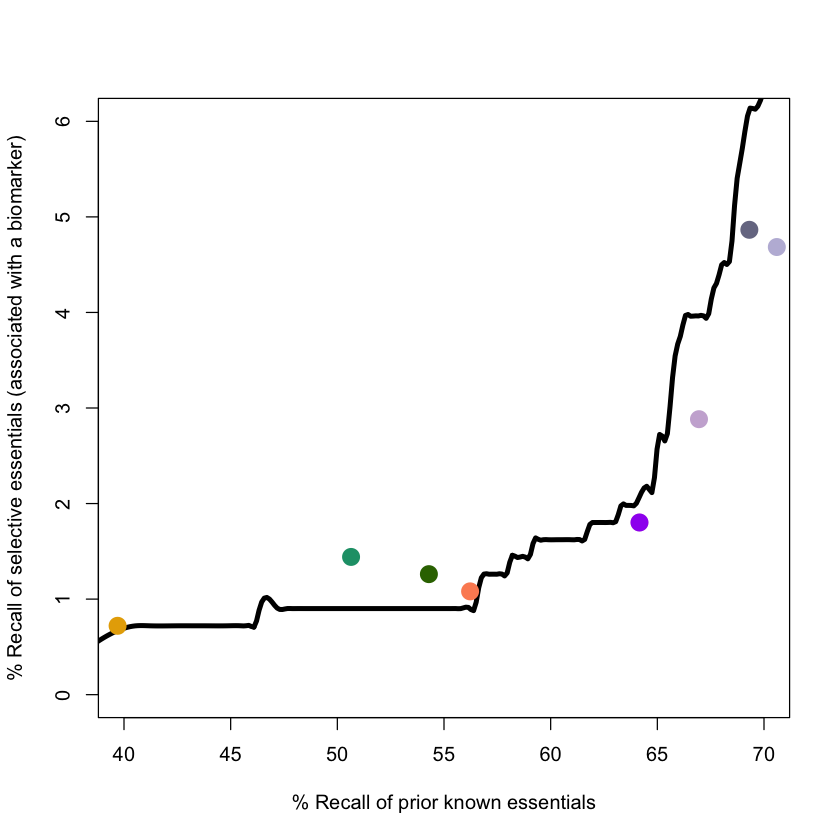

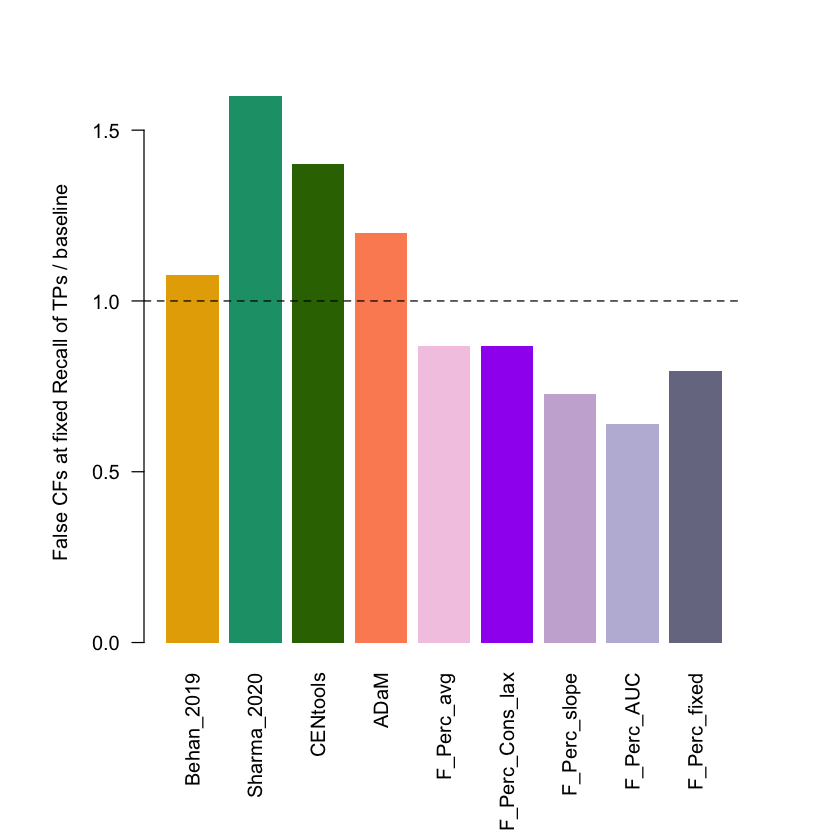

In [19]:
plot(spline(baselineRecalls,baselineNEratio),pch=16,
     xlab='% Recall of prior known essentials',
     ylab='% Recall of selective essentials (associated with a biomarker)',type='l',lwd=4,
     xlim=c(40,70),ylim=c(0,6))

points(observed_recalls,observed_FPs,col=col[names(observed_FPs)],pch=16,cex=2)

s0fun<-splinefun(baselineRecalls,baselineNEratio)

par(mar=c(8,6,4,4))
barplot(observed_FPs/s0fun(observed_recalls),col=col[names(observed_FPs)],
        las=2,border=NA,ylab='False CFs at fixed Recall of TPs / baseline')
abline(h=1,lty=2)

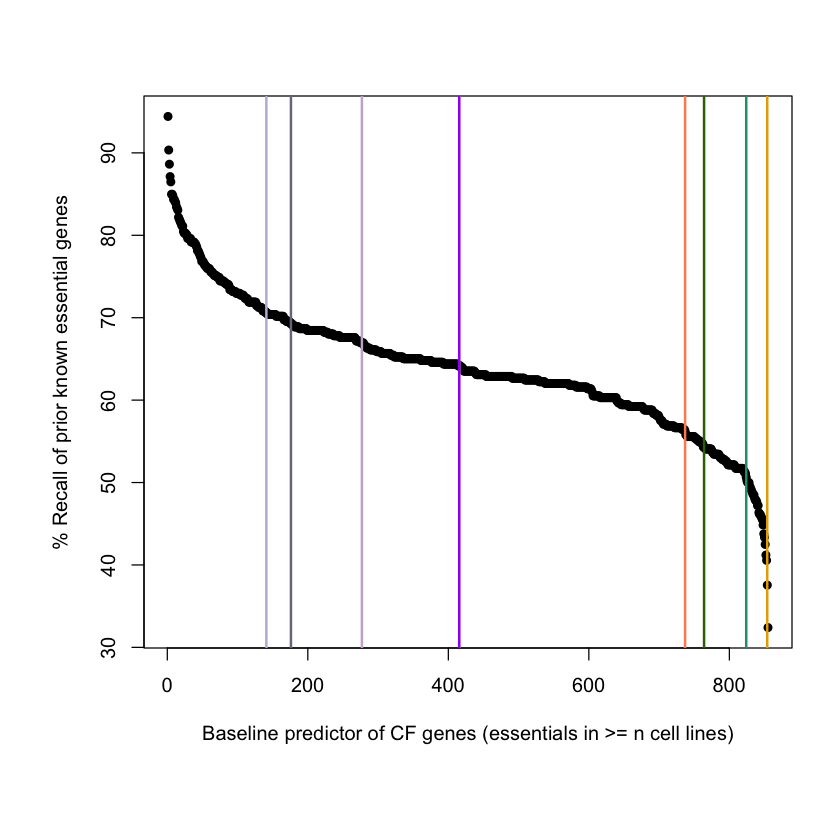

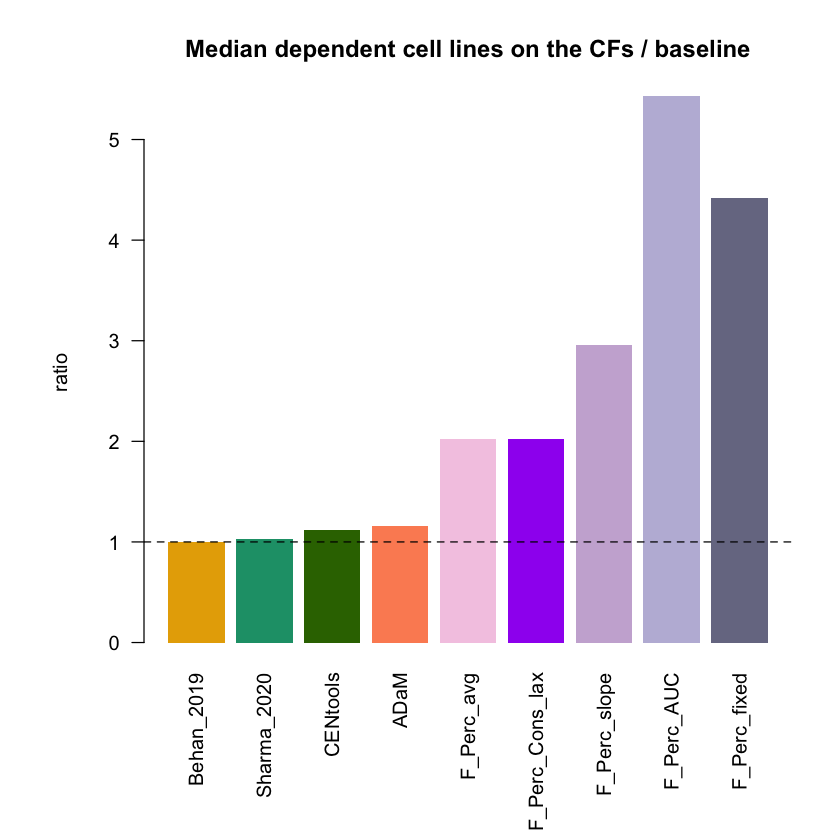

In [20]:
baselineRecalls<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,signatures))/length(signatures)
}))

par(mar=c(8,6,4,2))
plot(baselineRecalls,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of prior known essential genes',pch=16)

s0fun<-splinefun(baselineRecalls,1:length(baselineRecalls))
abline(v=s0fun(observed_recalls),col=col[names(observed_recalls)],lwd=2)

baseline_dep_cell_lines<-s0fun(observed_recalls)

median_n_dependent_cell_lines<-
  unlist(lapply(fCFs_sets,function(x){median(rowSums(bdep[intersect(x,geneSet),]))}))

barplot(median_n_dependent_cell_lines/baseline_dep_cell_lines,col=col[names(median_n_dependent_cell_lines)],
        las=2, border=NA,main = 'Median dependent cell lines on the CFs / baseline', ylab = 'ratio')
abline(h=1,lty=2)

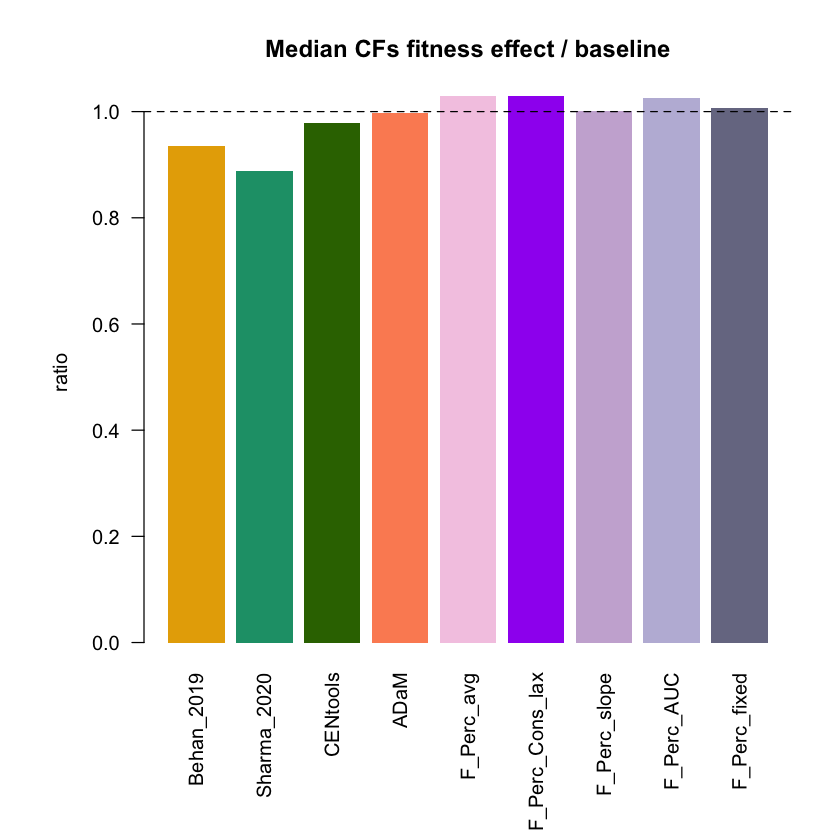

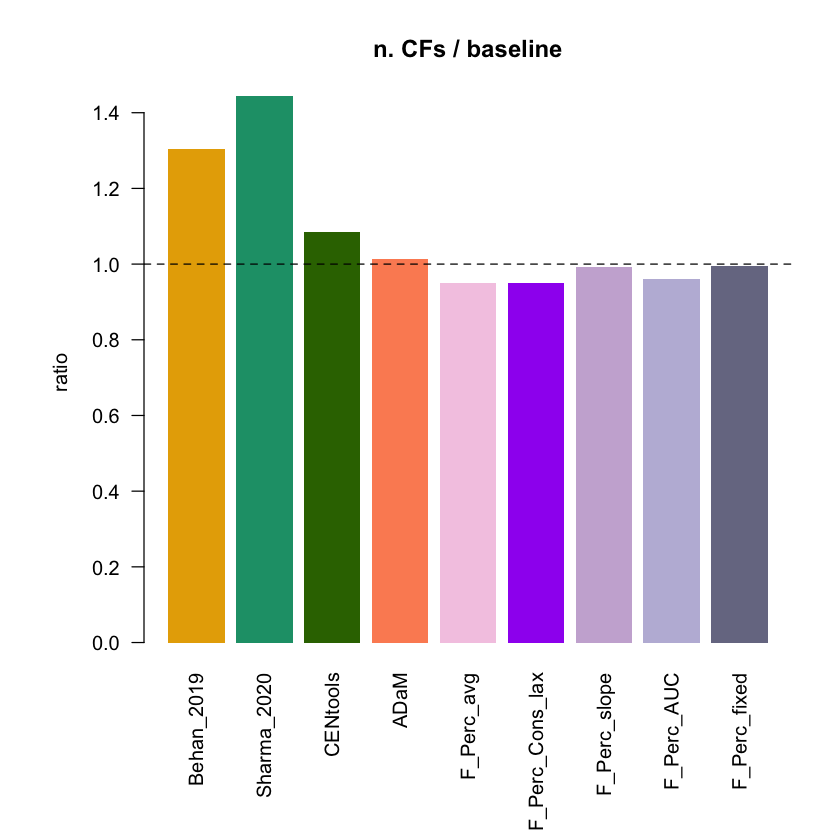

In [21]:
observed_sizes<-lapply(CFs_sets,length)

median_dep <- unlist(lapply(CFs_sets,
                function(x){median(apply(scaled_depFC[intersect(x,geneSet),],1,median))}))

baseline_dep <- unlist(lapply(baselineCFs[round(s0fun(observed_recalls))],
                function(x){median(apply(scaled_depFC[intersect(x,geneSet),],1,median))}))

par(mar=c(8,6,4,2))
barplot(median_dep/baseline_dep,col=col[names(median_dep)],
        las=2,main = 'Median CFs fitness effect / baseline', border=NA, ylab = 'ratio')
abline(h=1,lty=2)

baseline_size<-unlist(lapply(baselineCFs[round(s0fun(observed_recalls))],length))
observed_sizes<-unlist(observed_sizes)

barplot(observed_sizes/baseline_size,col=col[names(observed_sizes)],
        las=2,main = 'n. CFs / baseline',border=NA, ylab = 'ratio')
abline(h=1,lty=2)